In [18]:
# global settings

N_CPU = 12 # number of CPUs for parallel operations

In [19]:
# Already run this tutorial before? You can reload your data/models by running this cell and uncommenting the models/data you need.
from qsprpred.data.data import QSPRDataset
from qsprpred.models.interfaces import QSPRModel

# For the regression part of the tutorial
#dataset = QSPRDataset.fromFile('./qspr/data/tutorial_data_df.pkl')
# model = QSPRModel.fromFile('./qspr/models/PLS_REG/PLS_REG_meta.json')

# For the classification part of the tutorial
# dataset = QSPRDataset.fromFile('./qspr/data/A2A_LIGANDS_df.pkl')
# fitted_models = [QSPRModel.fromFile('./qspr/models/ExtraTreesClassifier/ExtraTreesClassifier_meta.json'),
#                  QSPRModel.fromFile('./qspr/models/RandomForestClassifier/RandomForestClassifier_meta.json')]

## Data Sets

QSPRPred package defines the `QSPRDataset` class, which is used to manage data and supply it to the models of interest. We will use example data sets that can be loaded via the `datasets.py` module defined in the current folder. Data sets can be created in a variety of ways so we encourage the reader to examine the documented examples in `datasets.py`.

## Building Models - Regression

### Preparing the Data

We will start with a regression example, which uses  the `Parkinsons` data set:

In [20]:
from datasets import Parkinsons

dataset = Parkinsons()
dataset.getDF()

Number of samples per target:
GABAAalpha    6280
NMDA          4073
P41594        2730
Q14416        1342
Q13255         975
Q14833         856
Q14832         172
O00222         153
O15303         104
Q14831          89
Q14643          12
Name: accession, dtype: int64


/zfsdata/data/linde/QSPRpred/src/qsprpred/qsprpred/data/data.py:119: UserWarning: Existing data set found, but also found a data frame in store. Refusing to overwrite data. If you want to overwrite data in store, set overwrite=True.
  warnings.warn(


,SMILES,GABAAalpha,NMDA,O00222,O15303,P41594,Q13255,Q14416,Q14643,Q14831,...,Descriptor_FingerprintSet_MorganFP_2039,Descriptor_FingerprintSet_MorganFP_2040,Descriptor_FingerprintSet_MorganFP_2041,Descriptor_FingerprintSet_MorganFP_2042,Descriptor_FingerprintSet_MorganFP_2043,Descriptor_FingerprintSet_MorganFP_2044,Descriptor_FingerprintSet_MorganFP_2045,Descriptor_FingerprintSet_MorganFP_2046,Descriptor_FingerprintSet_MorganFP_2047,Split_IsTrain
98,C(#Cc1c2COc3c(cccc3)-n2cn1)c1ccccc1,5.92,NaN,NaN,NaN,6.975,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
99,C(#Cc1c2COc3c(cccc3)-n2cn1)c1cccnc1,6.35,NaN,NaN,NaN,6.500,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
2318,CN1Cc2c(C#Cc3ccccc3)ncn2-c2c(C1=O)c(Cl)ccc2,9.00,NaN,NaN,NaN,5.950,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
2319,CN1Cc2c(C#Cc3ccccc3)ncn2-c2c(cc(F)cc2)C1=O,8.40,NaN,NaN,NaN,6.480,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
4131,Cc1cc(C#Cc2c3COc4c(cccc4)-n3cn2)ccc1,6.47,NaN,NaN,NaN,7.360,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
4132,Cc1cc(C#Cc2c3COc4c(cccc4)-n3cn2)ccn1,6.47,NaN,NaN,NaN,7.900,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
4141,Cc1cc(C#Cc2cn(-c3cc(S(C)(=O)=O)ccc3)c(C)n2)ccn1,5.50,NaN,NaN,NaN,6.800,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
4142,Cc1cc(C#Cc2cn(-c3ccc(C#N)cc3)c(C)n2)ccn1,5.50,NaN,NaN,NaN,7.120,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
4143,Cc1cc(C#Cc2cn(-c3ccc(F)cc3F)c(C)n2)ccn1,5.50,NaN,NaN,NaN,7.255,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
4144,Cc1cc(C#Cc2cn(-c3ccc(S(C)(=O)=O)cc3)c(C)n2)ccn1,5.50,NaN,NaN,NaN,6.550,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True


We will built a regression model for the GABA(A) receptor subunit alpha (GABAAalpha).
Therefore, we initialize our QSPRdataset as regression for "GABAAalpha".
After this we need to do some processing of the data.
We need to calculate compound features, split our dataset into a train and test set.

In [21]:
import os

from qsprpred.data.utils.descriptorsets import FingerprintSet
from qsprpred.data.utils.descriptorcalculator import DescriptorsCalculator
from sklearn.preprocessing import StandardScaler as Scaler
from qsprpred.data.utils.datasplitters import randomsplit

# Calculate MorganFP and physicochemical properties
feature_calculator = DescriptorsCalculator(descsets = [FingerprintSet(fingerprint_type="MorganFP", radius=3, nBits=2048)])

# Do a random split for creating the train (85%) and test set (15%)
rand_split = randomsplit(0.2)

# calculate compound features and split dataset into train and test
dataset.prepareDataset(
    split=rand_split,
    feature_calculator=feature_calculator,
    feature_standardizer=Scaler()
)

print(f"Number of samples train set: {len(dataset.y)}")
print(f"Number of samples test set: {len(dataset.y_ind)}")

Descriptors already exist in tutorial_data. Use `recalculate=True` to overwrite them.
Missing values filled with nan


Number of samples train set: 17
Number of samples test set: 5


In [22]:
# Let's save the dataset
dataset.save()

### Training the Model

After preparing our dataset, we will train a QSPR regression model.
In this tutorial we will train a XGBoost model as it generally performs well, but there are other model types
available. Most machine learning models have tunable hyperparameters (for example depth & learning rate), as some hyperparameter combinations will lead to better performance on a task we perform hyperparameter optimization (in which different combinations are tested and evaluated on a subset of the training data). After finding good hyperparameters a model will be trained on the training data & evaluated on the test data. In addition to this the final model will be trained on all data

In [23]:
from qsprpred.models.models import QSPRsklearn
from sklearn.cross_decomposition import PLSRegression

# This is an SKlearn model, so we will initialize it with the QSPRsklearn class
model = QSPRsklearn(base_dir = '.', data=dataset, alg = PLSRegression(), name='PLS_REG')

# We will first optimize the hyperparameters (n_components and scale) through bayes optimization
# the best hyperparameter combination will be saved in PLS_REG_GABAAalpha_params.json
search_space_bs = {"n_components": ["int", 1, 20], "scale": ["categorical", [True, False]]}
model.bayesOptimization(search_space_bs=search_space_bs, n_trials=5, n_jobs=4)

#Then we will evaluate the performance of the best model using the independent test set
_ = model.evaluate()

# Finally, we need to fit the model on the complete dataset if we want to use it further
# model is saved under qsprmodels/PLS_REG_GABAAalpha.pkg
model.fit()

At the moment n_jobs>1 not available for bayesoptimization. n_jobs set to 1
[I 2023-03-03 16:39:46,448] A new study created in memory with name: no-name-c0561e0a-414e-4ab4-9386-6d850f57e690
/home/linde/.conda/envs/QSPR/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:304: UserWarning: Y residual is constant at iteration 12
  warnings.warn(f"Y residual is constant at iteration {k}")
/home/linde/.conda/envs/QSPR/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:304: UserWarning: Y residual is constant at iteration 12
  warnings.warn(f"Y residual is constant at iteration {k}")
/home/linde/.conda/envs/QSPR/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:304: UserWarning: Y residual is constant at iteration 13
  warnings.warn(f"Y residual is constant at iteration {k}")
/home/linde/.conda/envs/QSPR/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:304: UserWarning: Y residual is constant at iteration 13
  warnings.warn(f"Y residual i

Bayesian optimization can take a while for some hyperparameter combinations
{'n_components': 17, 'scale': False}
{'n_components': 5, 'scale': False}


[I 2023-03-03 16:39:46,742] Trial 1 finished with value: 0.3080410134990851 and parameters: {'n_components': 5, 'scale': False}. Best is trial 0 with value: 0.30880877852798605.
/home/linde/.conda/envs/QSPR/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:304: UserWarning: Y residual is constant at iteration 12
  warnings.warn(f"Y residual is constant at iteration {k}")
/home/linde/.conda/envs/QSPR/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:304: UserWarning: Y residual is constant at iteration 12
  warnings.warn(f"Y residual is constant at iteration {k}")
[I 2023-03-03 16:39:46,874] Trial 2 finished with value: 0.30880877852798605 and parameters: {'n_components': 13, 'scale': False}. Best is trial 0 with value: 0.30880877852798605.
[I 2023-03-03 16:39:46,989] Trial 3 finished with value: 0.30892574184406674 and parameters: {'n_components': 6, 'scale': False}. Best is trial 3 with value: 0.30892574184406674.


{'n_components': 13, 'scale': False}
{'n_components': 6, 'scale': False}
{'n_components': 6, 'scale': True}


[I 2023-03-03 16:39:47,106] Trial 4 finished with value: 0.30892574184406685 and parameters: {'n_components': 6, 'scale': True}. Best is trial 4 with value: 0.30892574184406685.


## Evaluating the results

Plotting the results of our model on the test set we can see that it is performing well.

In [24]:
# we need to sve the model first
model.save()

'./qspr/models/PLS_REG/PLS_REG_meta.json'

<AxesSubplot: title={'center': 'PLS_REG (PLSRegression)'}, xlabel='Experimental GABAAalpha', ylabel='Predicted GABAAalpha'>

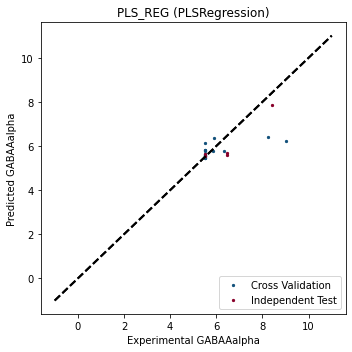

In [25]:
from qsprpred.plotting.regression import CorrelationPlot

plt = CorrelationPlot([model])
axes, summary = plt.make(save=False, property_name='GABAAalpha')
axes[0]

In [26]:
# the summary contains a data frame with some important metrics
summary

,ModelName,R2,RMSE,Set
0,PLS_REG,0.279218,0.850239,cv
1,PLS_REG,0.704507,0.575627,ind


## Building Models - Classification

### Preparing the Data

We will repeat the same steps as with the regression model, but this time with classification data loaded from `datasets.py`:

In [27]:
from qsprpred.data.utils.datasplitters import scaffoldsplit
from qsprpred.data.utils.descriptorcalculator import DescriptorsCalculator
from qsprpred.data.utils.descriptorsets import FingerprintSet
from qsprpred.data.utils.featurefilters import lowVarianceFilter, highCorrelationFilter
from qsprpred.data.utils.scaffolds import Murcko
from datasets import A2AR

# intialize the dataset
dataset = A2AR()

# Calculate MorganFP and physicochemical properties
feature_calculator = DescriptorsCalculator(descsets = [FingerprintSet(fingerprint_type="MorganFP", radius=3, nBits=2048)])

# Split on scaffolds
split = scaffoldsplit(dataset=dataset, scaffold=Murcko(), test_fraction=0.2)

# Remove features that have a low variance (<0.05) in the trainingset
lv = lowVarianceFilter(0.05)

# Remove features that have a high correlation (>0.9) in the trainingset
hc = highCorrelationFilter(0.8)

dataset.prepareDataset(
    split=split,
    feature_calculator=feature_calculator,
    feature_filters=[lv, hc]
)

# save the data set if you do not want to recalculate descriptors
# dataset.save()

print(f"Number of samples train set: {len(dataset.y)}")
print(f"Number of samples test set: {len(dataset.y_ind)}, {len(dataset.y_ind) / len(dataset.df) * 100}%")

You are downloading the high-quality Papyrus++ dataset.
Should you want to access the entire, though of lower quality, Papyrus dataset,
look into additional switches of this command.
Number of files to be downloaded: 3
Total size: 106MB


Using existing data from data/A2A_LIGANDS.tsv...


/zfsdata/data/linde/QSPRpred/src/qsprpred/qsprpred/data/data.py:119: UserWarning: Existing data set found, but also found a data frame in store. Refusing to overwrite data. If you want to overwrite data in store, set overwrite=True.
  warnings.warn(


Number of samples loaded: 4296


/zfsdata/data/linde/QSPRpred/src/qsprpred/qsprpred/data/data.py:119: UserWarning: Existing data set found, but also found a data frame in store. Refusing to overwrite data. If you want to overwrite data in store, set overwrite=True.
  warnings.warn(
Descriptors already exist in A2A_LIGANDS. Use `recalculate=True` to overwrite them.
Missing values filled with nan


Number of samples train set: 3418
Number of samples test set: 878, 20.43761638733706%


In [28]:
# Let's save the dataset
dataset.save()

In [29]:
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from qsprpred.models.models import QSPRsklearn

N_CPU = 12 # number of CPUs for parallel operations

params = {
    'n_estimators' : [50, 200],
    'criterion' : ['gini', 'entropy', 'log_loss'],
    "n_jobs": [1]
}


fitted_models = []
for model in [ExtraTreesClassifier, RandomForestClassifier]:
    model = QSPRsklearn(
        base_dir='.',
        data=dataset, 
        alg = model,
        name=model.__name__
    )

    model.gridSearch(search_space_gs=params, n_jobs=N_CPU)
    model.evaluate()
    model.fit()
    
    fitted_models.append(model)

fitted_models

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/zfsdata/data/linde/QSPRpred/src/qsprpred/qsprpred/models/models.py:80: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.model.fit(**fit_set)


Fitting 5 folds for each of 6 candidates, totalling 30 fits


/zfsdata/data/linde/QSPRpred/src/qsprpred/qsprpred/models/models.py:80: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.model.fit(**fit_set)


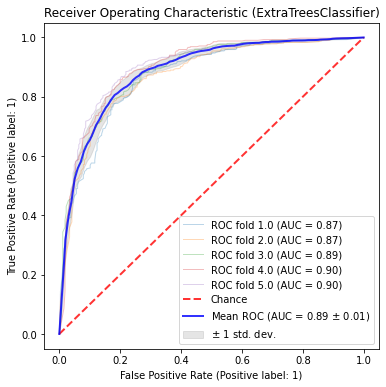

<Figure size 432x288 with 0 Axes>

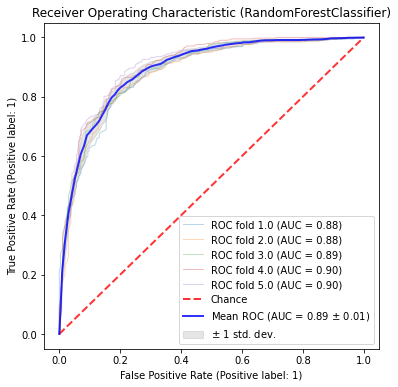

[<Figure size 432x432 with 1 Axes>, <Figure size 432x432 with 1 Axes>]

<Figure size 432x288 with 0 Axes>

In [30]:
from qsprpred.plotting.classification import ROCPlot

plot = ROCPlot(fitted_models)
plot.make("pchembl_value_Median_class", 'cv', save = True, show=True)

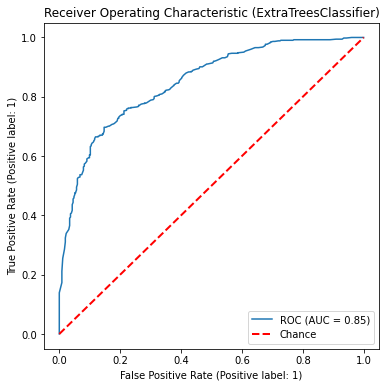

<Figure size 432x288 with 0 Axes>

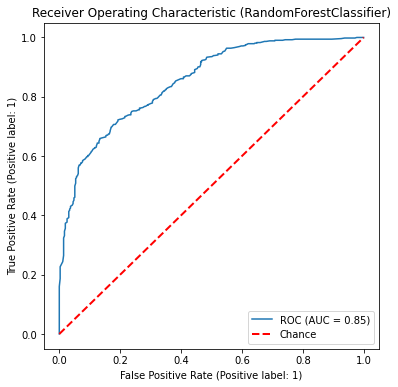

[<Figure size 432x432 with 1 Axes>, <Figure size 432x432 with 1 Axes>]

<Figure size 432x288 with 0 Axes>

In [31]:
plot.make("pchembl_value_Median_class", 'ind', save = True, show=True)

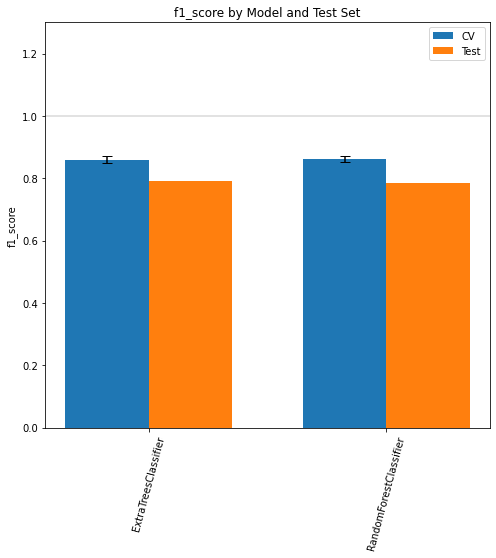

<Figure size 432x288 with 0 Axes>

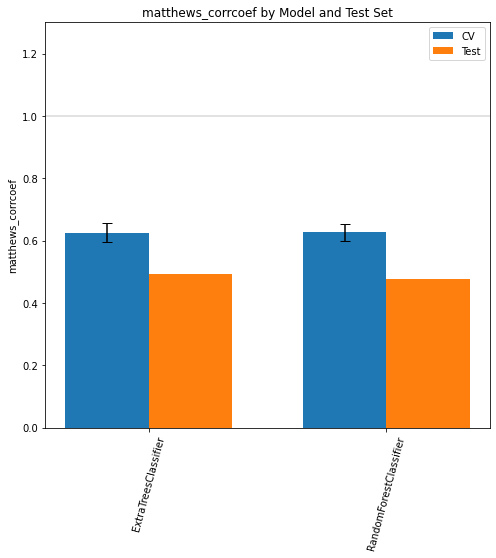

<Figure size 432x288 with 0 Axes>

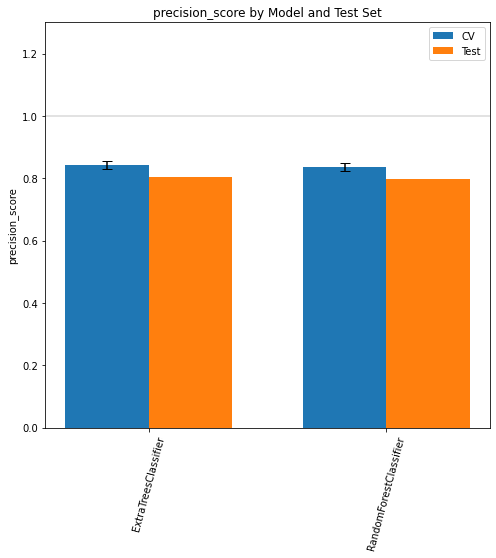

<Figure size 432x288 with 0 Axes>

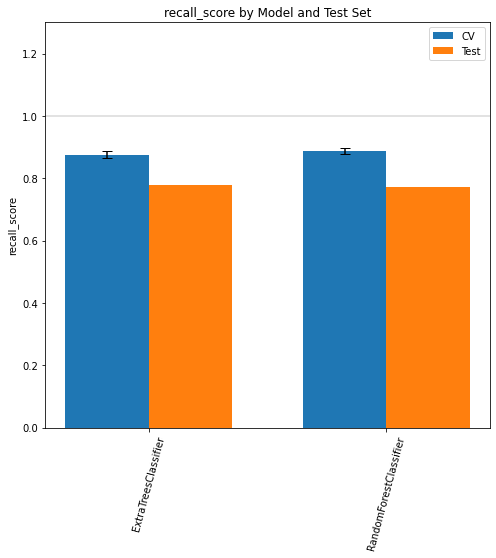

<Figure size 432x288 with 0 Axes>

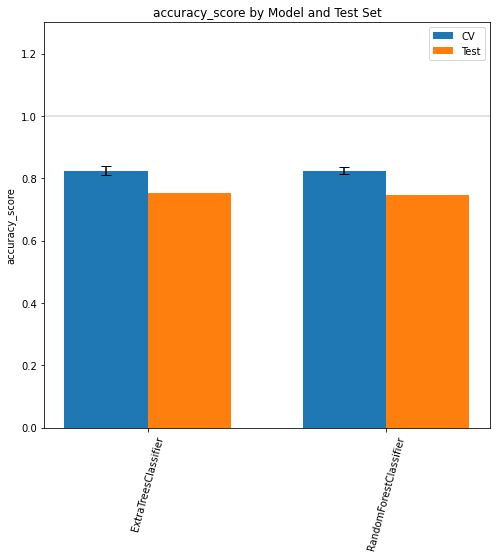

<Figure size 432x288 with 0 Axes>

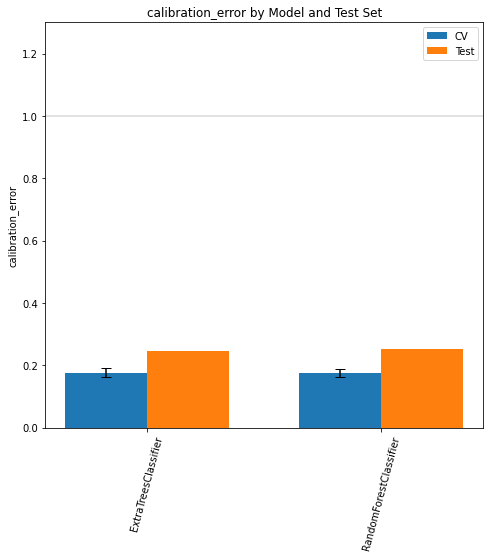

<Figure size 432x288 with 0 Axes>

In [32]:
from qsprpred.plotting.classification import MetricsPlot

plot = MetricsPlot(fitted_models)
figs, summary = plot.make("pchembl_value_Median_class", show=True, save=True, out_dir="qspr/models/")

In [33]:
# the summary contains the data frame with the metrics used to create the plots
summary

,Metric,Model,TestSet,Value
0,f1_score,ExtraTreesClassifier,CV1.0,0.857143
1,matthews_corrcoef,ExtraTreesClassifier,CV1.0,0.616981
2,precision_score,ExtraTreesClassifier,CV1.0,0.832957
3,recall_score,ExtraTreesClassifier,CV1.0,0.882775
4,accuracy_score,ExtraTreesClassifier,CV1.0,0.820175
...,...,...,...,...
67,matthews_corrcoef,RandomForestClassifier,IND,0.478338
68,precision_score,RandomForestClassifier,IND,0.797642
69,recall_score,RandomForestClassifier,IND,0.773333
70,accuracy_score,RandomForestClassifier,IND,0.747153


# Multitask regression model
Untill now, the examples have show models that predict one property (single task). In addition to this we can also make multitask models that are trained with multiple different properties simoultaneously.This can, for example, be a model that predicts the bioactivity on two or more proteins. Below, we will build a multitask model for 8 different human mGLU receptors.

Data on the mGLU receptors can also be found in the Parkinsons dataset. Here we specify that singletask is False, so that all the targets are set as properties to predict (see QSPRDataset). In addition to this mean imputation is used for missing values.

In [34]:
from datasets import Parkinsons

dataset = Parkinsons(singletask=False)

Feature calculation and dataset preparation is the same as for single task models. During splitting compounds are assigned to the training or test set (not individual datapoints).

In [35]:
import os

from qsprpred.data.utils.descriptorsets import FingerprintSet
from qsprpred.data.utils.descriptorcalculator import DescriptorsCalculator
from sklearn.preprocessing import StandardScaler as Scaler
from qsprpred.data.utils.datasplitters import randomsplit

# Calculate MorganFP and physicochemical properties
feature_calculator = DescriptorsCalculator(descsets = [FingerprintSet(fingerprint_type="MorganFP", radius=3, nBits=2048)])

# Do a random split for creating the train (85%) and test set (15%)
rand_split = randomsplit(0.2)

# calculate compound features and split dataset into train and test
dataset.prepareDataset(
    split=rand_split,
    feature_calculator=feature_calculator,
    feature_standardizer=Scaler()
)

print(f"Number of samples train set: {len(dataset.y)}")
print(f"Number of samples test set: {len(dataset.y_ind)}")

Missing values filled with nan


Number of samples train set: 4182
Number of samples test set: 1046


In [36]:
# Let's save the dataset
dataset.save()

# Training the model
We use a KNN model because it is relatively fast and the privously shown PLS does not work with multiple-tasks. Because hyperparameter optimization works the same as for single task models, we skip this step here.

In [37]:
from qsprpred.models.models import QSPRsklearn
from sklearn.neighbors import KNeighborsRegressor

# This is an SKlearn model, so we will initialize it with the QSPRsklearn class
model = QSPRsklearn(base_dir = '.', data=dataset, alg = KNeighborsRegressor(), name='KNN_REG_MT')

_ = model.evaluate()

# Finally, we need to fit the model on the complete dataset if we want to use it further
model.fit()

# and save the model
model.save()

'./qspr/models/KNN_REG_MT/KNN_REG_MT_meta.json'

# Model evaluation
Here we show how to calculate the metrics that are compatible with multitask model results using an SklearnMetric object. Currently imputed values are included in this analysis, the option to remove these from the analysis will be added soon.

In [38]:
from qsprpred.models.metrics import SklearnMetric

import pandas as pd

# get independent test set
df = pd.read_table("qspr/models/KNN_REG_MT/KNN_REG_MT.ind.tsv")

# column names containing original labels or predictions for the tasks
label_names = [i for i in list(df.columns.values) if "imputed_Label" in i] 
pred_names = [i for i in list(df.columns.values) if "imputed_Prediction" in i]
 
# turn into np array
ylabel = df[label_names].to_numpy()
ypred = df[pred_names].to_numpy()

# get metrics
summary = {}
for metric in SklearnMetric.multiTaskRegressionMetrics:
    scorer = SklearnMetric.getMetric(metric)
    score = scorer(ylabel, ypred)
    summary[metric]= score

summary["ModelName"] = model.name

summary

{'explained_variance': 0.2526137583075376,
 'neg_mean_absolute_error': -0.1264135520235015,
 'neg_mean_squared_error': -0.1139985859086805,
 'neg_root_mean_squared_error': -0.28793610475807296,
 'neg_mean_squared_log_error': -0.002393686685145768,
 'neg_median_absolute_error': -0.01780000000000015,
 'r2': 0.2411655152987533,
 'neg_mean_absolute_percentage_error': -0.021803360891433404,
 'ModelName': 'KNN_REG_MT'}

Lastly we plot the predicted pchembl values against the experimental results, to visualize model performance.

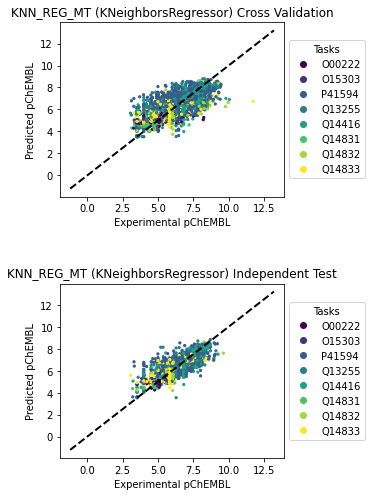

In [39]:
import math
from matplotlib import pyplot as plt
from sklearn import metrics
import numpy as np

property_name = "pChEMBL"

my_cmap = ["#12517B", "#88002A"]

plt.figure(figsize=(5, 7))
cate = ["qspr/models/KNN_REG_MT/KNN_REG_MT.cv.tsv", "qspr/models/KNN_REG_MT/KNN_REG_MT.ind.tsv"]
cate_names = ["cv", "ind"]
ret_axes = []
summary = {"ModelName": [], "R2": [], "RMSE": [], "Set": []}


for m, mymodel in enumerate([model]):
    min_val = 0
    max_val = 10
    for j, cate_name in enumerate(['Cross Validation', 'Independent Test']):
        ax = plt.subplot(2, len([model]), m + j + 1)
        ret_axes.append(ax)
        #todo create subplot show can show both plots
        df = pd.read_table(cate[j])
        # column names containing original labels or predictions for the tasks
        label_names = [i for i in list(df.columns.values) if "imputed_Label" in i]  #df[f"{property_name}_imputed_Label"]
        labels = [i.replace("_imputed_Label", '') for i in label_names]
        pred_names = [i for i in list(df.columns.values) if "imputed_Prediction" in i] #df[f"{property_name}_imputed_Prediction"]

        # # create mask with True if original value, False where no value in original  dataset
        # #TODO currently does not work because do not have df with cv / ind, nee
        # array = df_that_does_not_exist_yet[labels].to_numpy()
        # mask = ~np.isnan(array)
        
        # turn ylabel and ypred into np array
        ylabel = df[label_names].to_numpy()
        c = np.zeros(ylabel.shape)
        for k in range(c.shape[1]):
            c[:, k] = k
        c.flatten()
        
        ylabel = ylabel.flatten()
        ypred = df[pred_names].to_numpy().flatten()
        # mask = mask.flatten()

        # # no markers for inputed values
        # area = np.full(mask.shape, 5)
        # area1 = np.ma.masked_where(mask, area)
        # scatter = plt.scatter(
        #     ylabel,
        #     ypred,
        #     s=area1,
        #     c=c)

        scatter = plt.scatter(
            ylabel,
            ypred,
            s=5,
            c=c)
        coef = metrics.r2_score(ylabel, ypred)
        rmse = metrics.mean_squared_error(
            ylabel, ypred,
            squared=False)
        summary["R2"].append(coef)
        summary["RMSE"].append(rmse)
        summary["Set"].append(cate_names[j])
        summary["ModelName"].append(model.name)

        plt.title(f'{model} {cate_name}')
        plt.xlabel(f"Experimental {property_name}")
        plt.ylabel(f"Predicted {property_name}")
        min_val_now = math.floor(
            min(np.concatenate((ylabel, ypred))))
        max_val_now = math.ceil(
            max(np.concatenate((ylabel, ypred))))
        if min_val_now < min_val:
            min_val = min_val_now
        if max_val_now > max_val:
            max_val = max_val_now
        pad = (max_val - min_val) * 0.1
        plt.plot(
            [min_val - pad, max_val + pad],
            [min_val - pad, max_val + pad],
            lw=2, linestyle='--', color='black')

        handles, _ = scatter.legend_elements()

        plt.legend(handles, labels, title="Tasks", loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.subplots_adjust(wspace=0.3, hspace=0.5)

In [40]:
summary

{'ModelName': ['KNN_REG_MT', 'KNN_REG_MT'],
 'R2': [0.8195353817972051, 0.8417181923856422],
 'RMSE': [0.35906696847515623, 0.3376367662276733],
 'Set': ['cv', 'ind']}